In [1]:
!pip install unidecode

In [0]:
from IPython.display import Image
from IPython.core.display import HTML

from IPython.display import clear_output

In [0]:
# from google.colab import files
# uploaded = files.upload()

# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [0]:
# import unidecode
# import string
# import random
# import re

# all_characters = string.printable
# n_characters = len(all_characters)

# file = unidecode.unidecode(open('all_story.txt').read())
# file_len = len(file)
# print('file_len =', file_len)

In [0]:
import random

def read_file(filename): 
  text = open(filename, 'r', encoding = "utf-8-sig").read().splitlines()
  text = " ".join(text)
  return text

import string
import unicodedata

#all_characters = string.ascii_letters + string.punctuation + string.digits + " "
all_characters = string.printable
n_characters = len(all_characters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_characters
    )

In [0]:
file = read_file("all_story.txt")

In [0]:
file = unicodeToAscii(file)
file_len = len(file)

In [8]:
file_len

23456194

In [9]:
n_characters

100

To make inputs out of this big string of data, we will be splitting it into chunks.

In [10]:
chunk_len = 100

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

d girl with a swelling pride upon her, as much as to say, "I told you so!" The old girl relieves her 


# **Train and Validation**

In [0]:
validation_fraction = 0.7
validation_idx = int(file_len*(1-validation_fraction))
train_data, val_data = file[:validation_idx], file[validation_idx:]

In [12]:
len(train_data)

7036858

In [13]:
len(val_data)

16419336

# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, model ="gru"):
        super(CharRNN, self).__init__()
        self.model = str(model).lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
             
        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, dropout = 0.5)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, dropout = 0.5)
        self.decoder = nn.Linear(hidden_size, output_size)

#     def forward(self, input, hidden):
#         batch_size = input.size(0)
#         encoded = self.encoder(input)
#         output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
#         output = self.decoder(output.view(batch_size, -1))
#         return output, hidden

    def forward(self, input, hidden, use_softmax=False):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = output.contiguous().view(batch_size, hidden_size) 
        output = F.dropout(output, 0.5)
        output = self.decoder(output).view(batch_size, -1)
        return (F.softmax(output,dim=2), hidden) if use_softmax else (output, hidden)

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [15]:
torch.zeros(2, 8, 4)

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(42)

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [18]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [0]:
def random_dataset(chunk_len, batch_size, dataset):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, len(dataset) - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = dataset[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    if device == "cuda":
        inp = inp.cuda()
        target = target.cuda()
    return inp, target


In [20]:
random_dataset(10, 16, file)

(tensor([[14, 13, 94, 29, 17, 27, 24, 30, 16, 17],
         [94, 14, 23, 29, 18, 27, 14, 21, 34, 94],
         [94, 24, 15, 94, 29, 17, 14, 94, 32, 18],
         [18, 23, 94, 18, 29, 28, 94, 18, 27, 27],
         [29, 18, 24, 23, 94, 24, 15, 94, 23, 10],
         [14, 27, 14, 23, 29, 94, 13, 14, 16, 27],
         [16, 94, 10, 29, 94, 29, 17, 14, 94, 49],
         [28, 94, 10, 23, 28, 32, 14, 27, 94, 29],
         [29, 27, 14, 10, 22, 18, 23, 16, 94, 17],
         [10, 23, 16, 14, 27, 73, 94, 11, 24, 29],
         [55, 17, 14, 94, 25, 24, 24, 27, 94, 16],
         [20, 14, 94, 24, 15, 94, 55, 14, 21, 21],
         [23, 10, 23, 12, 14, 94, 29, 17, 10, 29],
         [14, 22, 73, 94, 15, 24, 27, 94, 17, 14],
         [14, 10, 27, 21, 34, 94, 20, 23, 24, 32],
         [94, 32, 14, 94, 16, 24, 94, 29, 24, 94]], device='cuda:0'),
 tensor([[13, 94, 29, 17, 27, 24, 30, 16, 17, 94],
         [14, 23, 29, 18, 27, 14, 21, 34, 94, 24],
         [24, 15, 94, 29, 17, 14, 94, 32, 18, 23],
         [23

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [0]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=device):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda == "cuda":
      prime_input = prime_input.cuda()
      if isinstance(hidden, tuple):
        hidden = (hidden[0].cuda(), hidden[1].cuda())
      else: 
        hidden = hidden.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted

# Training

A helper to print the amount of time passed:

In [0]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [0]:
# def train(inp, target):
#     hidden = decoder.init_hidden(batch_size)
#     if device == "cuda":
#       if model == "gru": 
#         hidden = hidden.cuda() 
#       else:
#         hidden = (hidden[0].cuda(), hidden[1].cuda())
#     decoder.zero_grad()
#     loss = 0

#     for c in range(chunk_len):
#         output, hidden = decoder(inp[:,c], hidden)
#         loss += criterion(output.view(batch_size, -1), target[:,c])

#     loss.backward()
#     decoder_optimizer.step()
    
#     train_loss = loss.item() / chunk_len

#     #return loss.data[0] / chunk_len
#     return train_loss

In [0]:
def train(train_inp, train_target, val_inp, val_target):
    hidden = decoder.init_hidden(batch_size)
    if device == "cuda":
      if model == "gru": 
        hidden = hidden.cuda() 
      else:
        hidden = (hidden[0].cuda(), hidden[1].cuda())
    decoder.zero_grad()
    
    loss = 0
    val_loss = 0
    
    decoder.train(True)
    for c in range(chunk_len):
        output, hidden = decoder(train_inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), train_target[:,c])
        #loss += criterion(output.view(batch_size*chunk_len, -1), train_target[:,c])
    loss.backward()
    decoder_optimizer.step()  
    t_loss = loss.item() / chunk_len
    
    #validation loss
    decoder.train(False)
    for c in range(chunk_len):
      output, hidden = decoder(val_inp[:,c], hidden)
      val_loss += criterion(output.view(batch_size, -1), val_target[:,c])
      #val_loss += criterion(output.view(batch_size*chunk_len, -1), val_target[:,c])
    v_loss = val_loss.item() / chunk_len  

    #return loss.data[0] / chunk_len
    return t_loss, v_loss

In [0]:
import os 
def save():
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(decoder, save_filename)
    print('Saved as %s' % save_filename)

Then we define the training parameters, instantiate the model, and start training:

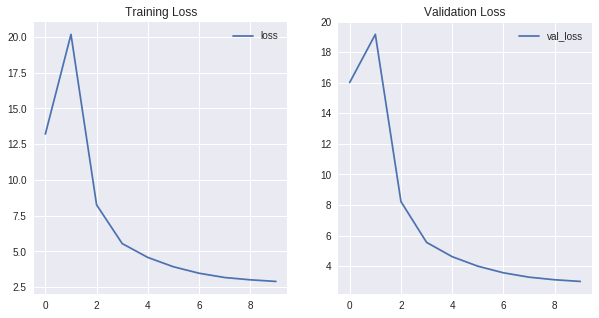

number of epochs completed: 100
========== generated samples ==========
 37s (100 100%) 2.8614]
Whe he of lofvhe we nen tht tyed fmaiiy wpen crensd sesrreamnot aved the apottke waant yn wy sresec th 

Saving...
Saved as char-rnn.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type CharRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [26]:
model = 'gru'
n_epochs = 100
hidden_size = 512
n_layers = 2
learning_rate = 0.05
chunk_len = 100
batch_size = 512

filename = "char-rnn"
print_every = 100
plot_every = 10

decoder = CharRNN(n_characters, hidden_size, n_characters, n_layers, model)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

if device == "cuda":
    decoder.cuda()

start = time.time()
all_losses = []
val_losses = []
loss_avg = 0
vloss_avg = 0

try:
    print("Training for %d epochs..." % n_epochs)
    for epoch in range(1, n_epochs + 1): 
        t_loss, v_loss = train(*random_dataset(chunk_len, batch_size, train_data), *random_dataset(chunk_len, batch_size, val_data))
        loss_avg += t_loss
        vloss_avg += v_loss

#         if epoch % print_every == 0:
#             print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
#             print(generate(decoder, 'Wh', 100, cuda=device), '\n')
            
        if epoch % plot_every == 0:
          all_losses.append(loss_avg / plot_every)
          val_losses.append(vloss_avg / plot_every) # new
          loss_avg = 0
          vloss_avg = 0 # new
          clear_output(wait=True)
          plt.figure(figsize=(10, 5)) # new
          
          plt.subplot(121) # new
          plt.plot(all_losses, label = "loss")
          plt.legend() #new
          plt.title("Training Loss") #new
          
          plt.subplot(122)
          plt.plot(val_losses, label = "val_loss") #new
          plt.legend() #new
          plt.title("Validation Loss") #new
          
          plt.pause(0.05)
          
          print("number of epochs completed:", epoch)
          print("========== generated samples ==========")
          print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, t_loss))
          print(generate(decoder, 'Wh', 100, cuda=device), '\n')

    print("Saving...")
    save()

except KeyboardInterrupt:
    print("Saving before quit...")
    save()
    
if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

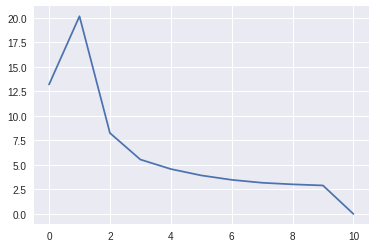

In [27]:
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [30]:
start = ["a", "b", "c", "d", "e", "f"]
for i in start: 
  print(generate(decoder, i, predict_len=100, temperature=0.5, cuda=device))

RuntimeError: ignored

Lower temperatures are less varied, choosing only the more probable outputs:

In [29]:
print(generate(decoder, 'T', predict_len=1000, temperature=0.2, cuda=device))

RuntimeError: ignored

Higher temperatures more varied, choosing less probable outputs:

In [0]:
print(generate(decoder, 'Th', predict_len=200, temperature=1.4, cuda=device))